# Model Selection

---

__This Notebook__

- plot learning curves to assess overfitting

__Results__ 


## Setup

In [1]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import confusion_matrix

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-02-11


## Load

In [9]:
# load target vector
raw_path = os.path.join("data","1_raw")
y_df = pd.read_csv(os.path.join(raw_path, 'y_train.csv'))
y_array = np.array(y_df.iloc[:,0].ravel())

y = y_array.copy()

# transform y_array into int type
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load matrix
proc_dir = os.path.join("data", "2_processed")
X = sp.load_npz(os.path.join(proc_dir, 'X_tfidf_svd800_spamcos.npz'))

## Helpful Functions


In [10]:
 
# evaluate classifier
def eval_clf(y_val, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_val, 
                                      y_pred).ravel()
    confmat_df = pd.DataFrame(
        np.array(([tn, fp], [fn, tp])),
        columns=['pred_neg', 'pred_pos'], 
        index=['cond_neg', 'cond_pos']
    )
    # unpack metrics
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    # print results
    print(confmat_df)
    print(f'acc: {acc:0.4f}')
    print(f'tpr: {tpr:0.4f}')
    print(f'tnr: {tnr:0.4f}')

def extract_df(gd):
    gd_res = gd.cv_results_
    df = pd.concat([
                    pd.DataFrame(gd_res["params"]),
                    pd.DataFrame(gd_res["mean_train_acc"], columns=["mean_train_acc"]),
                    pd.DataFrame(gd_res["mean_train_tpr"], columns=["mean_train_tpr"]),
                    pd.DataFrame(gd_res["mean_train_tnr"], columns=["mean_train_tnr"]),
                    pd.DataFrame(gd_res["mean_test_acc"], columns=["mean_val_acc"]),
                    pd.DataFrame(gd_res["mean_test_tpr"], columns=["mean_val_tpr"]),
                    pd.DataFrame(gd_res["mean_test_tnr"], columns=["mean_val_tnr"]),
                    pd.DataFrame(gd_res["mean_fit_time"], columns=["mean_fit_time"])
                    #pd.DataFrame(gd_res["std_test_acc"], columns=["std_val_acc"]),
                    #pd.DataFrame(gd_res["std_test_tpr"], columns=["std_val_tpr"]),
                    #pd.DataFrame(gd_res["std_test_tnr"], columns=["std_val_tnr"]),
                   ]
                   , axis=1)
    return df

##  Gradient Boosting Classifier


```
class GradientBoostingClassifier(ClassifierMixin, BaseGradientBoosting):
    """Gradient Boosting for classification.
    GB builds an additive model in a
    forward stage-wise fashion; it allows for the optimization of
    arbitrary differentiable loss functions. In each stage ``n_classes_``
    regression trees are fit on the negative gradient of the
    binomial or multinomial deviance loss function. Binary classification
    is a special case where only a single regression tree is induced.
```

See [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), [code](https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/ensemble/_gb.py#L768)

__Some defaults:__


- `loss='deviance'`
- `learning_rate=0.1`
- `n_estimators=100`
- `subsample=1.0`
- `criterion='friedman_mse'`
- `min_samples_split=2`
- `min_samples_leaf=1`
- `min_weight_fraction_leaf=0.0`
- `max_depth=3`
- `min_impurity_decrease=0.0`
- `min_impurity_split=None`
- `init=None`
- `random_state=None`
- `max_features=None`
- `verbose=0`
- `max_leaf_nodes=None`
- `warm_start=False`
- `validation_fraction=0.1`
- `n_iter_no_change=None`
- `tol=0.0001`
- `ccp_alpha=0.0`

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier

## GridSearchCV

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [13]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 12))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [20]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

title1 = r"Learning Curves (GGC, defaults)"
title2 = r"Learning Curves (GBC, best)"

estimator1 = GradientBoostingClassifier(
    random_state=42
)
estimator2 = GradientBoostingClassifier(
    random_state=42, 
    max_depth=8, 
    max_features=300, 
    min_samples_split=5, 
    n_estimators=100
)

Elapsed: 8 m 12 s


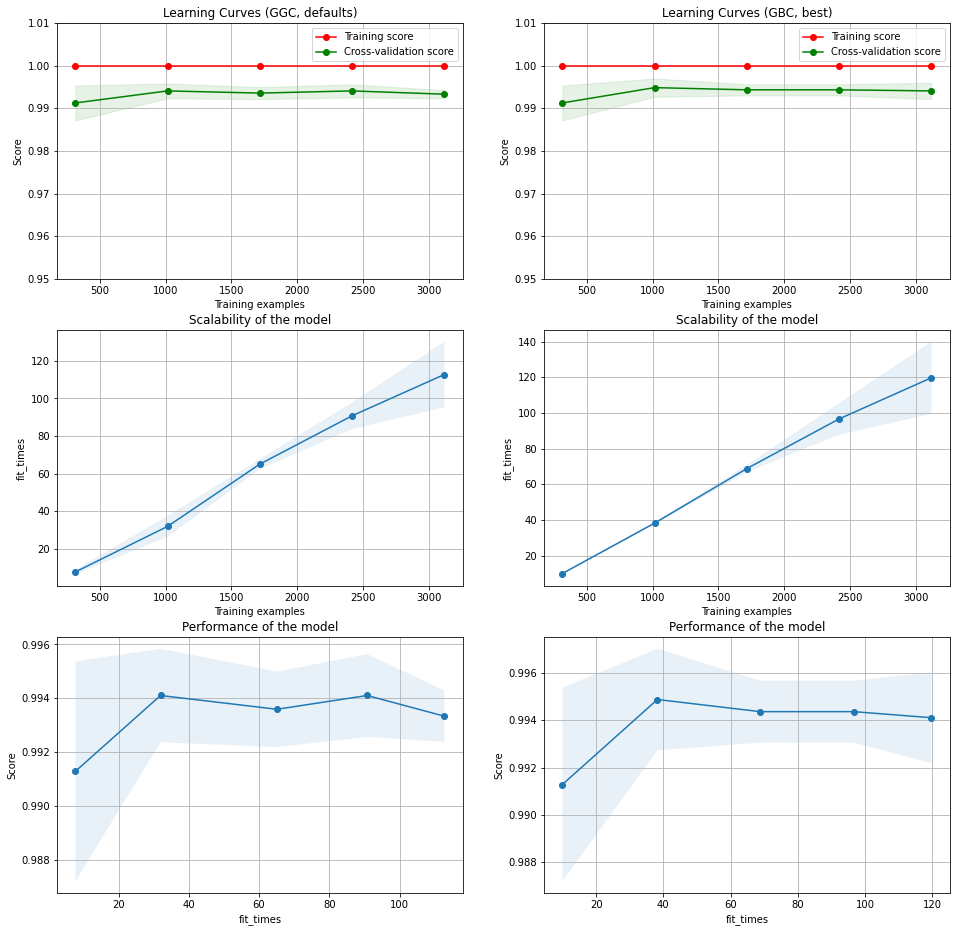

In [21]:
t1 = time.time()
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
plot_learning_curve(estimator1, title1, X, y, axes=axes[:, 0], ylim=(0.95, 1.01),
                    cv=cv, n_jobs=-1)
plot_learning_curve(estimator2, title2, X, y, axes=axes[:, 1], ylim=(0.95, 1.01),
                    cv=cv, n_jobs=-1)
m, s = divmod(time.time() - t1, 60)
print(f'Elapsed: {m:0.0f} m {s:0.0f} s')
plt.show()

Investigate [learning_curve](https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/model_selection/_validation.py#L1215) to switch scoring to include sensitivity and specificity.

In [ ]:

    # setup scorers
    scorers = {
        'acc': make_scorer(accuracy_score),
        'tpr': make_scorer(recall_score, pos_label=1), # sensitivity, recall
        'tnr': make_scorer(recall_score, pos_label=0) # specificity, selectivity
    }


    # instantiate k-fold gridsearch
    cv_folds = StratifiedKFold(n_splits=k)
    
    grid_search_clf = GridSearchCV(clf, 
                                   param_grid,
                                   scoring=scorers, 
                                   refit='tpr', 
                                   cv=cv_folds, 
                                   return_train_score=True, 
                                   n_jobs=n_jobs,
                                   verbose=1)
    
    # train models
    grid_search_clf.fit(X_train, y_train)

    # predict
    y_pred = grid_search_clf.predict(X_val)
    print(f'Best params: {grid_search_clf.best_params_}')

    # eval metrics
    print('Evaluation metrics:')
    eval_clf(y_val, y_pred)
    
    return grid_search_clf

---